In [98]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import pickle
from scipy import stats
import numpy as np
import math


In [45]:
# load ripple results
session_list = [i for i in range(60)]
session_list = [2,4,5]
result_path =  "/Users/xpsy1114/Documents/projects/multiple_clocks/data/ephys_humans/derivatives"
# check if on server or local
if not os.path.isdir(result_path):
    print("running on ceph")
    result_path = "/ceph/behrens/svenja/human_ABCD_ephys/derivatives"

power_dict = {}
ripple_events = {}
beh = {}
column_names = ['rep_correct', 't_A', 't_B', 't_C', 't_D', 'loc_A', 'loc_B', 'loc_C', 'loc_D', 'rep_overall', 'new_grid_onset', 'session_no', 'grid_no']
for s_idx in session_list:
    sesh = f"s{s_idx:02}"
    #power dictionary
    power_path = f"{result_path}/{sesh}/LFP-ripples/ripple_power_dict_{sesh}"
    with open(power_path, 'rb') as f:
        power_dict[sesh] = pickle.load(f)
    # behavioural table
    beh_path = f"{result_path}/{sesh}/cells_and_beh/all_trial_times_{s_idx:02}.csv"
    beh[sesh] = pd.read_csv(beh_path, header=None) 
    beh[sesh].columns = column_names
    # ripple events table
    ripple_path = f"{result_path}/{sesh}/LFP-ripples/ripples_{sesh}.csv"
    ripple_events[sesh] = pd.read_csv(ripple_path)
    

In [34]:
print(f"overview of ripple event table for sessions {sesh}")
print(len(ripple_event_dict[sesh]))
ripple_events[sesh].sort_values('onset_in_secs').head()

overview of ripple event table for sessions s05
263


,onset_in_secs,onset_in_samples,duration,channel,grid_no,task,snippet
80,20.182,6046,0.022,RT2cHcEb01-141,grid1,6421,8.09-55.27sec
76,20.364,6137,0.020,LT1Ha01-082,grid1,6421,8.09-55.27sec
77,27.694,9802,0.024,LT1Ha01-082,grid1,6421,8.09-55.27sec
78,28.614,10262,0.022,RT1bHb01-132,grid1,6421,8.09-55.27sec
81,32.750,12330,0.024,RT2cHcEb01-141,grid1,6421,8.09-55.27sec


In [40]:
print(f"overview of behavioural table for sessions {sesh}")
print(len(beh[sesh]))
beh[sesh].head()

overview of behavioural table for sessions s05
152


,rep_correct,t_A,t_B,t_C,t_D,loc_A,loc_B,loc_C,loc_D,rep_overall,new_grid_onset,session_no,grid_no
0,0,18.488,28.378,35.198,55.267,6,4,2,1,1,14.098,1,1
1,0,69.188,77.017,86.888,139.340,6,4,2,1,2,55.267,1,1
2,0,169.590,176.220,184.550,186.030,6,4,2,1,3,139.340,1,1
3,0,215.600,222.430,226.490,227.700,6,4,2,1,4,186.030,1,1
4,0,235.190,241.690,296.030,304.290,6,4,2,1,5,227.700,1,1


In [28]:
print(f"overview of power dictionary structure {sesh}")
print()
def print_dict_structure(d, indent=0):
    prefix = "  " * indent
    if isinstance(d, dict):
        for key, value in d.items():
            if isinstance(value, dict):
                print(f"{prefix}{key}/ (dict)")
                print_dict_structure(value, indent + 1)
            elif isinstance(value, list):
                print(f"{prefix}{key} - list of length {len(value)}")
                if value and isinstance(value[0], dict):
                    print(f"{prefix}  [0]/ (dict in list)")
                    print_dict_structure(value[0], indent + 2)
            else:
                print(f"{prefix}{key} - {type(value).__name__}")
    else:
        print(f"{prefix}- {type(d).__name__}: {d}")

print_dict_structure(power_dict[sesh])

overview of power dictionary structure s05

752.66-762.48sec_grid3_ABCD_5897_500_Hz/ (dict)
  LFP_mean_power/ (dict)
    theta - ndarray
    SW - ndarray
    middle - ndarray
    hgamma - ndarray
    ultra_high_gamma - ndarray
  LFP_stepwise_power/ (dict)
    theta - ndarray
    SW - ndarray
    middle - ndarray
    hgamma - ndarray
    ultra_high_gamma - ndarray
2222.50-2234.50sec_grid10_ABCD_3726_500_Hz/ (dict)
  LFP_mean_power/ (dict)
    theta - ndarray
    SW - ndarray
    middle - ndarray
    hgamma - ndarray
    ultra_high_gamma - ndarray
  LFP_stepwise_power/ (dict)
    theta - ndarray
    SW - ndarray
    middle - ndarray
    hgamma - ndarray
    ultra_high_gamma - ndarray
1178.40-1191.50sec_grid5_ABCD_3427_500_Hz/ (dict)
  LFP_mean_power/ (dict)
    theta - ndarray
    SW - ndarray
    middle - ndarray
    hgamma - ndarray
    ultra_high_gamma - ndarray
  LFP_stepwise_power/ (dict)
    theta - ndarray
    SW - ndarray
    middle - ndarray
    hgamma - ndarray
    ultra_high_g

In [43]:
# sort timings in 'plan', 'explore' and 'repeat' for each grid.
beh_phases = {}
for sesh in beh:
    phases = []

    for grid_id, group in beh[sesh].groupby("grid_no"):
        group = group.sort_values(by="rep_overall")  # Ensure order

        # Find 'explore' phase
        first_row = group[group['rep_correct'] == 0].iloc[0]
        explore_start = first_row['new_grid_onset']
        explore_end = first_row['t_D']

        # Find 'plan' phase
        last_plan_row = group[group['rep_correct'] == 0].iloc[-1]
        plan_start = explore_end
        plan_end = last_plan_row['t_D']

        # Find 'repeat' phase
        max_rep_row = group.loc[group['rep_overall'].idxmax()]
        repeat_start = plan_end
        repeat_end = max_rep_row['t_D']

        # Add to list
        phases.append({
            'grid_no': grid_id,
            'phase': 'explore',
            'start': explore_start,
            'end': explore_end
        })
        phases.append({
            'grid_no': grid_id,
            'phase': 'plan',
            'start': plan_start,
            'end': plan_end
        })
        phases.append({
            'grid_no': grid_id,
            'phase': 'repeat',
            'start': repeat_start,
            'end': repeat_end
        })
    
    # Create result DataFrame
    beh_phases[sesh] = pd.DataFrame(phases)
    beh_phases[sesh]['duration'] = beh_phases[sesh]['end'] - beh_phases[sesh]['start']

beh_phases[sesh].head()

,grid_no,phase,start,end,duration
0,1,explore,14.098,55.267,41.169
1,1,plan,55.267,325.870,270.603
2,1,repeat,325.870,422.300,96.430
3,2,explore,427.780,465.090,37.310
4,2,plan,465.090,499.800,34.710


In [56]:
#compute the ripple rate per grid. 
ripple_rates = {}
for sesh in beh: 
    # Ensure grid numbers are consistently typed
    beh_phases[sesh]['grid_no'] = beh_phases[sesh]['grid_no'].astype(str)
    ripple_events[sesh]['grid_no'] = ripple_events[sesh]['grid_no'].str.extract(r'(\d+)')  # Extract numeric part from 'grid1'
    ripple_events[sesh]['grid_no'] = ripple_events[sesh]['grid_no'].astype(str)

    # Prepare an empty list to collect results
    results = []

    # Loop through each phase
    for _, phase_row in beh_phases[sesh].iterrows():
        grid = phase_row['grid_no']
        phase = phase_row['phase']
        start = phase_row['start']
        end = phase_row['end']
        duration = phase_row['duration']

        # Get matching ripples
        ripples_in_phase = ripple_events[sesh][
            (ripple_events[sesh]['grid_no'] == grid) &
            (ripple_events[sesh]['onset_in_secs'] >= start) &
            (ripple_events[sesh]['onset_in_secs'] < end)
        ]

        # Calculate ripple rate
        ripple_count = len(ripples_in_phase)
        ripple_rate = ripple_count / duration if duration > 0 else 0

        results.append({
            'grid_no': grid,
            'phase': phase,
            'ripple_count': ripple_count,
            'duration': duration,
            'ripple_rate': ripple_rate
        })
    
    ripple_rates[sesh]= pd.DataFrame(results)
ripple_rates[sesh].head()

,grid_no,phase,ripple_count,duration,ripple_rate
0,1,explore,7,41.169,0.170031
1,1,plan,24,270.603,0.088691
2,1,repeat,3,96.430,0.031111
3,2,explore,3,37.310,0.080407
4,2,plan,1,34.710,0.028810


In [57]:
all_results = []  # Collect all per-session dataframes here

for sesh in beh:
    # Ensure grid numbers are consistently typed
    beh_phases[sesh]['grid_no'] = beh_phases[sesh]['grid_no'].astype(str)
    ripple_events[sesh]['grid_no'] = ripple_events[sesh]['grid_no'].str.extract(r'(\d+)')
    ripple_events[sesh]['grid_no'] = ripple_events[sesh]['grid_no'].astype(str)

    results = []

    for _, phase_row in beh_phases[sesh].iterrows():
        grid = phase_row['grid_no']
        phase = phase_row['phase']
        start = phase_row['start']
        end = phase_row['end']
        duration = phase_row['duration']

        ripples_in_phase = ripple_events[sesh][
            (ripple_events[sesh]['grid_no'] == grid) &
            (ripple_events[sesh]['onset_in_secs'] >= start) &
            (ripple_events[sesh]['onset_in_secs'] < end)
        ]

        ripple_count = len(ripples_in_phase)
        rate = ripple_count / duration if duration > 0 else 0

        results.append({
            'session': sesh,
            'grid_no': grid,
            'phase': phase,
            'ripple_count': ripple_count,
            'duration': duration,
            'ripple_rate': rate
        })

    all_results.append(pd.DataFrame(results))

# Combine all into a single DataFrame
ripple_rates_df = pd.concat(all_results, ignore_index=True)
ripple_rates_df.head()

,session,grid_no,phase,ripple_count,duration,ripple_rate
0,s02,1,explore,1,58.55,0.017079
1,s02,1,plan,0,9.77,0.000000
2,s02,1,repeat,0,56.08,0.000000
3,s02,2,explore,1,28.35,0.035273
4,s02,2,plan,1,11.60,0.086207


In [70]:
summary.head()

,phase,mean,sem,session
0,explore,0.077674,0.015559,s05
1,plan,0.064077,0.009526,s05
2,repeat,0.103379,0.010859,s05


In [69]:
# compute stats per session.
# Store session-level stats
session_stats = []

for sesh, group in ripple_rates_df.groupby('session'):
    summary = group.groupby('phase')['ripple_rate'].agg(['mean', 'sem']).reset_index()
    summary['session'] = sesh

    # Pairwise t-tests between phases
    def get_rates(phase): return group[group['phase'] == phase]['ripple_rate']
    try:
        t_explore_plan = stats.ttest_rel(get_rates('explore'), get_rates('plan'))
        t_plan_repeat = stats.ttest_rel(get_rates('plan'), get_rates('repeat'))
        t_explore_repeat = stats.ttest_rel(get_rates('explore'), get_rates('repeat'))
    except Exception as e:
        print(f"Error in t-tests for session {sesh}: {e}")
        t_explore_plan = t_plan_repeat = t_explore_repeat = [np.nan, np.nan]

    session_stats.append({
        'session': sesh,
        'means': summary.set_index('phase')['mean'].to_dict(),
        'sems': summary.set_index('phase')['sem'].to_dict(),
        't_explore_vs_plan_p': t_explore_plan.pvalue,
        't_plan_vs_repeat_p': t_plan_repeat.pvalue,
        't_explore_vs_repeat_p': t_explore_repeat.pvalue
    })
    
stats_df = pd.DataFrame(session_stats)
stats_df.head()


,session,means,sems,t_explore_vs_plan_p,t_plan_vs_repeat_p,t_explore_vs_repeat_p
0,s02,"{'explore': 0.011778148604280203, 'plan': 0.01...","{'explore': 0.0038281766745439936, 'plan': 0.0...",0.978316,0.191396,0.026369
1,s04,"{'explore': 0.010363054850144474, 'plan': 0.03...","{'explore': 0.005032968132853272, 'plan': 0.02...",0.328720,0.273966,0.713953
2,s05,"{'explore': 0.07767446082133185, 'plan': 0.064...","{'explore': 0.015559371624087328, 'plan': 0.00...",0.466147,0.034659,0.266135


In [107]:
# Utility: turn p-value into stars
def p_to_star(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'n.s.'

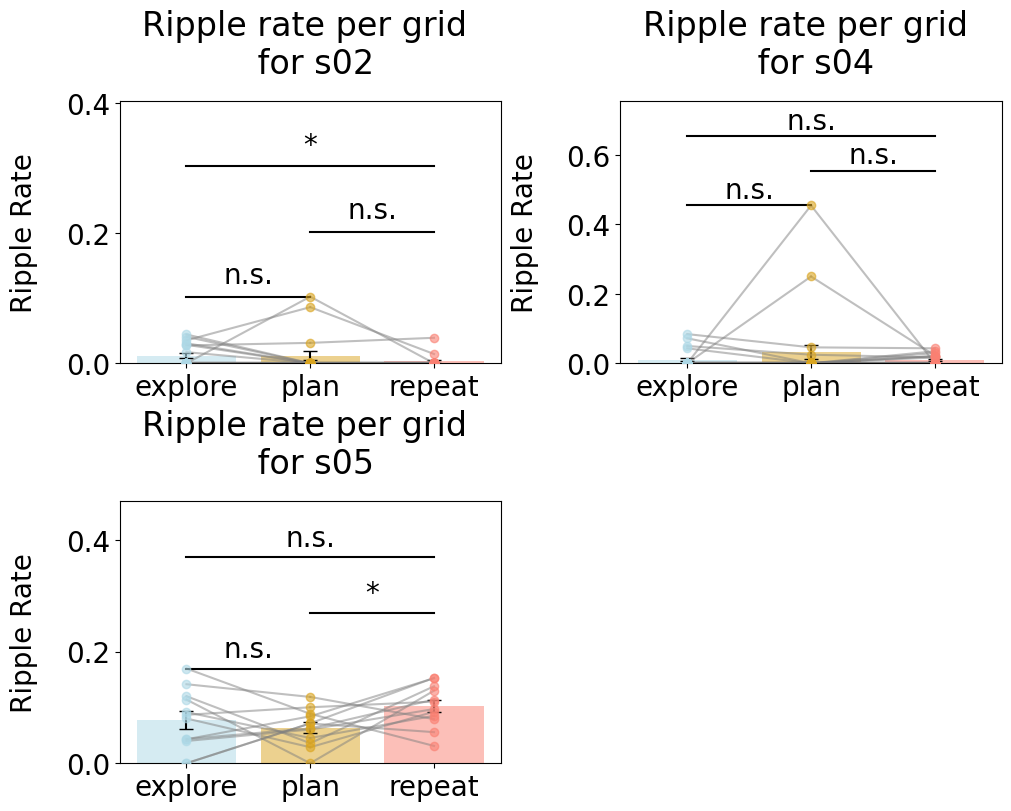

In [123]:
n_sessions = len(stats_df)
colors = ['lightblue','goldenrod', 'salmon']
plt.rcParams.update({'font.size': 20})

# dynamically compute rows and columns of subplots
n_rows, n_cols = math.ceil(n_sessions / math.ceil(n_sessions**0.5)), math.ceil(n_sessions**0.5)
# Create figure and axis
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4), constrained_layout=True)
axes = axes.flatten()
    
for idx, row in stats_df.iterrows():
    ax = axes[idx]
    # Plot the bars
    ax.bar(row['means'].keys(), row['means'].values(), yerr=row['sems'].values(), capsize=5, color=colors, alpha=0.5)
    
    # Prepare plotting the scatter points for individual data points (i.e. ripple rates per task)
    data_curr_sesh = ripple_rates_df[ripple_rates_df['session']==row['session']]
    ripple_rate_curr_sesh_phase= []
    for idx_p, phase in enumerate(row['means'].keys()):
        ripple_rate_curr_sesh_phase.append(data_curr_sesh[data_curr_sesh['phase']==phase]['ripple_rate'].values)
        ax.scatter(np.ones(len(ripple_rate_curr_sesh_phase[idx_p]))*idx_p, ripple_rate_curr_sesh_phase[idx_p], color=colors[idx_p], alpha=0.6, zorder=3)
    
    # connect the ripple rate datapoint of each task across phases to demonstrate trajectory
    for i_task, ripple_rate_in_task in enumerate(ripple_rate_curr_sesh_phase[idx]):
        ax.plot([0,1], [ripple_rate_curr_sesh_phase[0][i_task], ripple_rate_curr_sesh_phase[1][i_task]], color='gray', alpha=0.5, zorder=2)  # Connecting lines
        ax.plot([1,2], [ripple_rate_curr_sesh_phase[1][i_task], ripple_rate_curr_sesh_phase[2][i_task]], color='gray', alpha=0.5, zorder=2)  # Connecting lines
        
    

    # Compute max y for star placement
    all_vals = np.concatenate(ripple_rate_curr_sesh_phase)
    y_max = all_vals.max()
    
    # Draw line and star between plan and first_correct solve (plan)
    ax.plot([0, 1], [y_max]*2, color='black')
    ax.text(0.5, y_max + 0.02, p_to_star(row['t_explore_vs_plan_p']), ha='center')

    # Draw line and star between first_correct_rate and all_reps_rate
    ax.plot([1, 2], [y_max + 0.1]*2, color='black')
    ax.text(1.5, y_max + 0.12, p_to_star(row['t_plan_vs_repeat_p']), ha='center')

    # Draw line and star between find_ABCD_rate and all_reps_rate
    ax.plot([0, 2], [y_max + 0.2]*2, color='black')
    ax.text(1.0, y_max + 0.22, p_to_star(row['t_explore_vs_repeat_p']), ha='center')

    
    # final plot adjustments
    # Adjust y-limits to accommodate lines and stars
    ax.set_ylim(0, y_max + 0.3)

    # Adding labels
    ax.set_ylabel('Ripple Rate', labelpad=20)
    ax.set_xticks(ticks=[0, 1, 2], rotation = 45)
    ax.set_title(f"Ripple rate per grid \n for {row['session']}", pad=20)
    #ax.tight_layout()
    
# Turn off unused axes
for j in range(idx+1, len(axes)):
    axes[j].axis('off')

# Show the plot
plt.show()

    

In [67]:
# compute stats collapsed across all sessions.
# Group all by phase, ignoring session
collapsed_summary = ripple_rates_df.groupby('phase')['ripple_rate'].agg(['mean', 'sem']).reset_index()

# Pairwise t-tests (all data)
explore_rates = ripple_rates_df[ripple_rates_df['phase'] == 'explore']['ripple_rate']
plan_rates = ripple_rates_df[ripple_rates_df['phase'] == 'plan']['ripple_rate']
repeat_rates = ripple_rates_df[ripple_rates_df['phase'] == 'repeat']['ripple_rate']

t_explore_plan = stats.ttest_rel(explore_rates, plan_rates)
t_plan_repeat = stats.ttest_rel(plan_rates, repeat_rates)
t_explore_repeat = stats.ttest_rel(explore_rates, repeat_rates)

collapsed_stats = {
    'means': collapsed_summary.set_index('phase')['mean'].to_dict(),
    'sems': collapsed_summary.set_index('phase')['sem'].to_dict(),
    't_explore_vs_plan_p': t_explore_plan.pvalue,
    't_plan_vs_repeat_p': t_plan_repeat.pvalue,
    't_explore_vs_repeat_p': t_explore_repeat.pvalue
}

stats_collapsed_seshs_df = pd.DataFrame(collapsed_stats)
stats_collapsed_seshs_df.head()

from pprint import pprint
print("\nCollapsed stats across sessions:")
pprint(collapsed_stats)

,means,sems,t_explore_vs_plan_p,t_plan_vs_repeat_p,t_explore_vs_repeat_p
explore,0.025538,0.005587,0.543785,0.649072,0.758415
plan,0.032072,0.009973,0.543785,0.649072,0.758415
repeat,0.027249,0.006101,0.543785,0.649072,0.758415


In [ ]:
mc.analyse.plotting_ripples.plot_ripple_count_three_bars(ripples_per_task_all_subs, sub)
    
    
    

In [ ]:
# prepare plotting some ripples.
freq_to_plot = 500

def load_snippet(file_name):
    


In [ ]:
# ripple plotting function.
# requires the raw snippet, the event timings, and the power.


plot_ripple(freq_to_plot, title, downsampled_data, event, min_length_ripple, filtered_cropped_vhgamma_np, power_dict, repeat, freq_bands_keys, y_label_power, for_publication = False):

downsampled_data = load_snippet(snippet_name)
    
x = np.arange(-freq_to_plot, freq_to_plot) * 2
    

plt.rcParams.update({'font.size': 20})
fig, axs = plt.subplots(2)
# here, plot only 40ms before and after the event
no_of_samples = 0.03*freq_to_plot
x = np.arange(-no_of_samples, no_of_samples) * 2
freq_to_plot = int(no_of_samples)


# only plot half of this:
# freq_to_plot = freq_to_plot/2
# Create x-values from 5500 to 9500
# x = np.linspace(event[0]-freq_to_plot, event[0]+freq_to_plot-1, freq_to_plot*2)


# the fifth subplot is the overall power spectrum
# power_to_plot_all = np.stack(power_all[freq_bands_keys[0]][event[-1], :, event[0]-sampling_freq:event[0]+sampling_freq], power_all[freq_bands_keys[1]][event[-1], :, event[0]-sampling_freq:event[0]+sampling_freq], power_all[freq_bands_keys[2]][event[-1], :, event[0]-sampling_freq:event[0]+sampling_freq])
power_to_plot_all = np.vstack((power_dict[f"{repeat}_stepwise"][freq_bands_keys[0]][event[-1], :, event[0]-freq_to_plot:event[0]+freq_to_plot], power_dict[f"{repeat}_stepwise"][freq_bands_keys[1]][event[-1], :, event[0]-freq_to_plot:event[0]+freq_to_plot]))
power_to_plot_all = np.vstack((power_to_plot_all, power_dict[f"{repeat}_stepwise"][freq_bands_keys[2]][event[-1], :, event[0]-freq_to_plot:event[0]+freq_to_plot]))
power_to_plot_all = np.vstack((power_to_plot_all, power_dict[f"{repeat}_stepwise"][freq_bands_keys[3]][event[-1], :, event[0]-freq_to_plot:event[0]+freq_to_plot]))
y_ticks = [5, 25, 45, 65, power_to_plot_all.shape[0] - 1]  # 5, 25, 45, 65 and the max value (y-axis max)


axs[1].set_title('downsampled raw LFP', pad=20)
axs[1].set_xlabel('Time (ms)')
# set a few x-ticks around the ripple in 20ms resolution. 
axs[1].plot(x, downsampled_data[event[0]-freq_to_plot:event[0]+freq_to_plot, event[-1]], linewidth = 2, color='black')
axs[1].set_xticks(np.arange(0-3*min_length_ripple, 4*min_length_ripple, 1.5*min_length_ripple))  # Set x-ticks from 0 to 10 with a step of 0.5

axs[0].imshow(power_to_plot_all, aspect='auto', origin='lower')
axs[0].set_xticks([])
# Setting the yticks and the labels
axs[0].set_title('power spectrum', pad = 20)
axs[0].set_yticks(y_ticks[:-1])  # Add the desired tick positions except the last one
axs[0].set_yticks([y_ticks[-1]], minor=True)  # Add the max position as a minor tick
axs[0].set_yticklabels(y_label_power)  # Add the desired tick labels